# Removing Glasses from an image through recursive PCA

## Setup Data

### Import Necessary Libraries

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

### Load Data

In [2]:
# Load Imgaes Images as Dataset
def load_pgm_images(amount_of_people, amount_of_pics):
    images = []
    for person in range(1, amount_of_people+1):
        images.append([])
        for image_number in range(1, amount_of_pics+1):
            img = Image.open('images/s' + str(person) + '/' + str(image_number) + '.pgm')
            images[person-1].append(img)
    return np.array(images)
    
def display_pgm_images(images, person_numbers, pic_numbers):
    rows, cols = len(person_numbers), len(pic_numbers)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 8))

    row = 0
    for i in person_numbers:
        col = 0
        for j in pic_numbers:
            ax = axes[row, col]
            ax.imshow(images[i][j], cmap='gray')
            ax.axis('off')
            col += 1
        row += 1
    plt.tight_layout()
    plt.show()

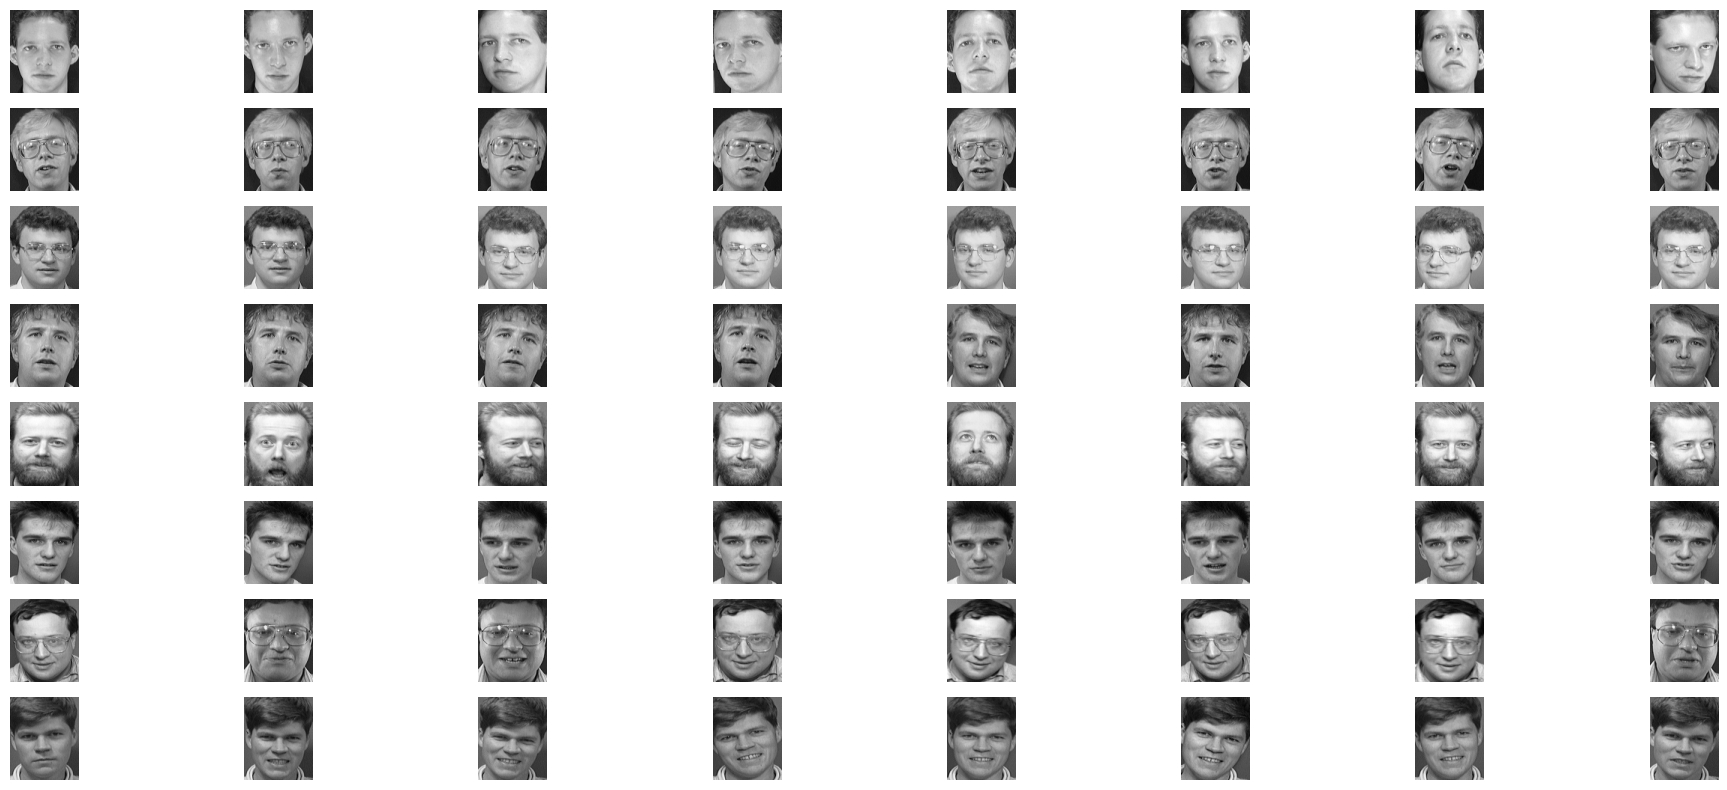

In [3]:
# Example of images
amount_of_people = 40
amount_of_pics = 10
person_numbers = [0, 1, 5, 14, 25, 29, 30, 32]
pic_numbers = [0, 2, 3, 5, 6, 7, 8, 9]
images = load_pgm_images(40, 10)
display_pgm_images(images, person_numbers, pic_numbers)

Note: The images folder contains 40 folders, each with 10 images (each folder is of a different person, and each of the 10 images contains different features of the person). Each image is 112x92 pixels

### Process Data

(10304, 230)


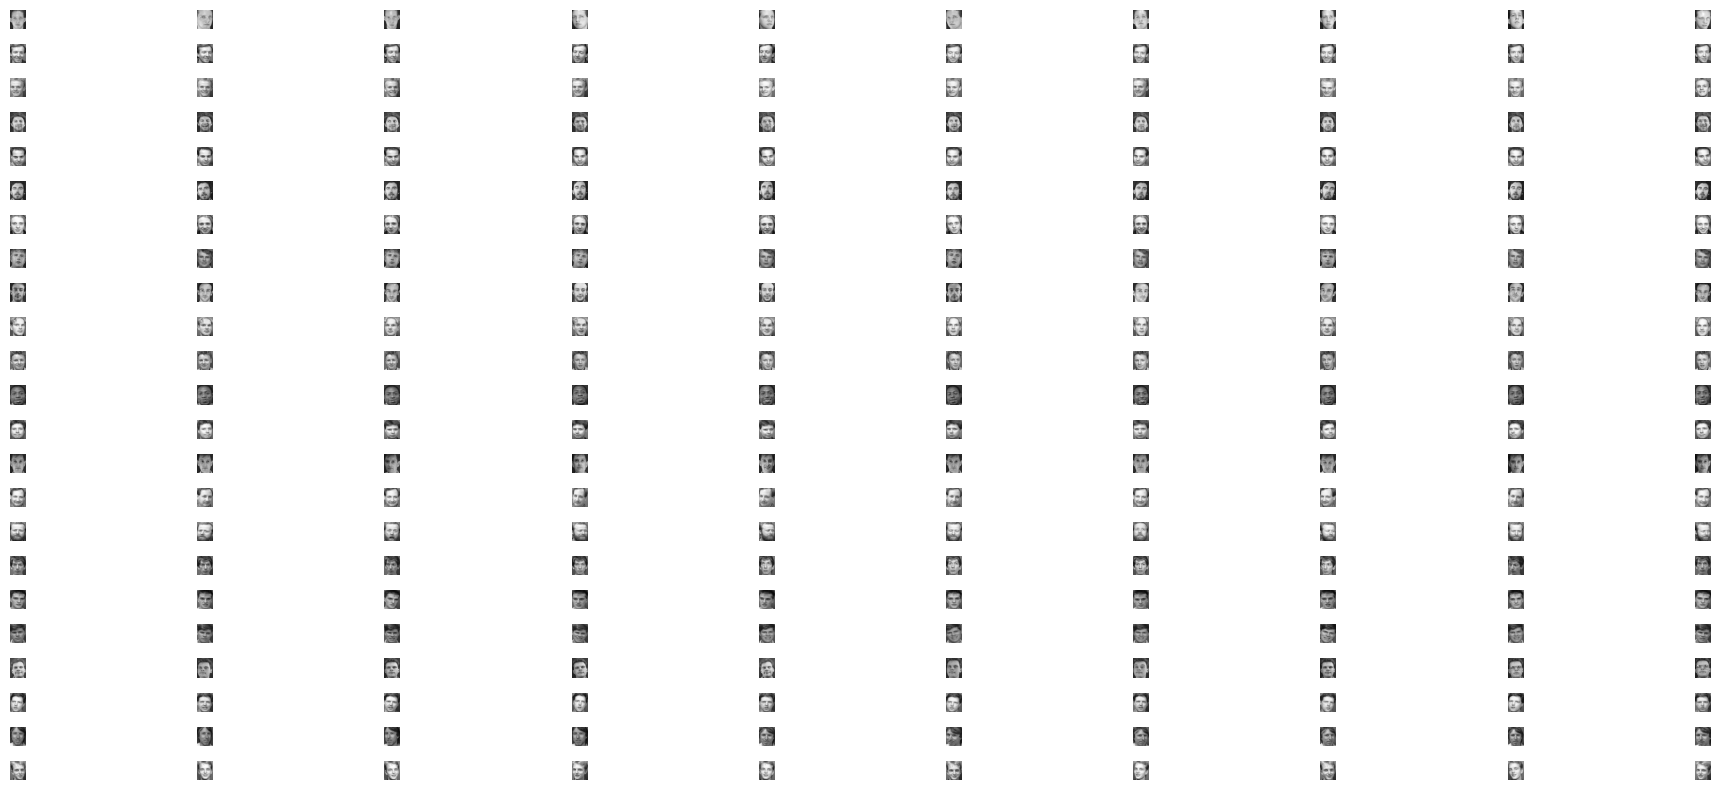

In [4]:
# Create Dataset of Male and Without Glasses
selected_people = [0, 2, 4, 6, 8, 10, 11, 14, 15, 17, 20, 21, 22, 23, 24, 25, 28, 29, 32, 35, 37, 38, 39]
male_no_glasses_imgs = np.array([images[i] for i in selected_people])
selected_imgs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create Dataset for male with no glasses to perform PCA with
num_people = len(selected_people)
num_pictures = len(selected_imgs)
num_pixels = 112 * 92
ds = np.zeros((num_people, num_pictures, num_pixels))

# Function flattens matrix to n x 1 column
def flatten_matrix(matrix):
    return matrix.reshape(-1)

# flatten pixels
for i in range(num_people):
    for j in range(num_pictures):
        ds[i][j] = flatten_matrix(male_no_glasses_imgs[i][j])

# Flatten pictures
ds = ds.reshape(num_people * num_pictures, num_pixels)
ds = ds.T
print(ds.shape)

# Display selected pictures
display_pgm_images(images, selected_people, selected_imgs)

## Perform PCA on Glassless Dataset

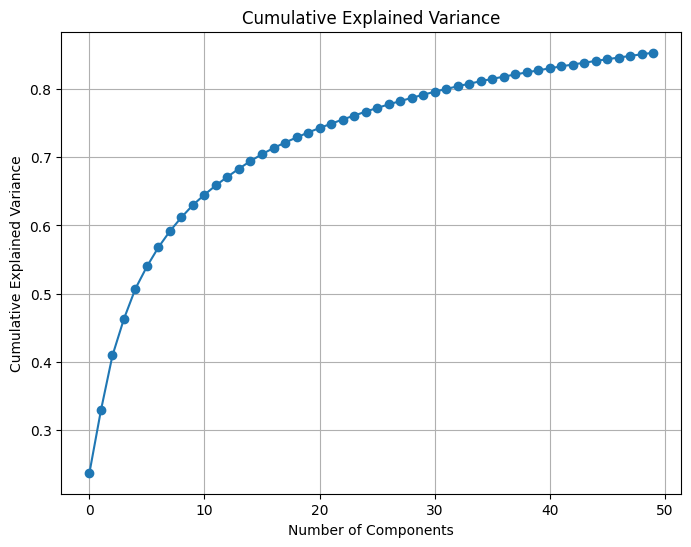

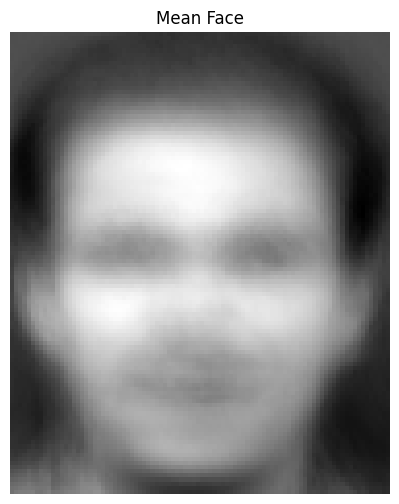

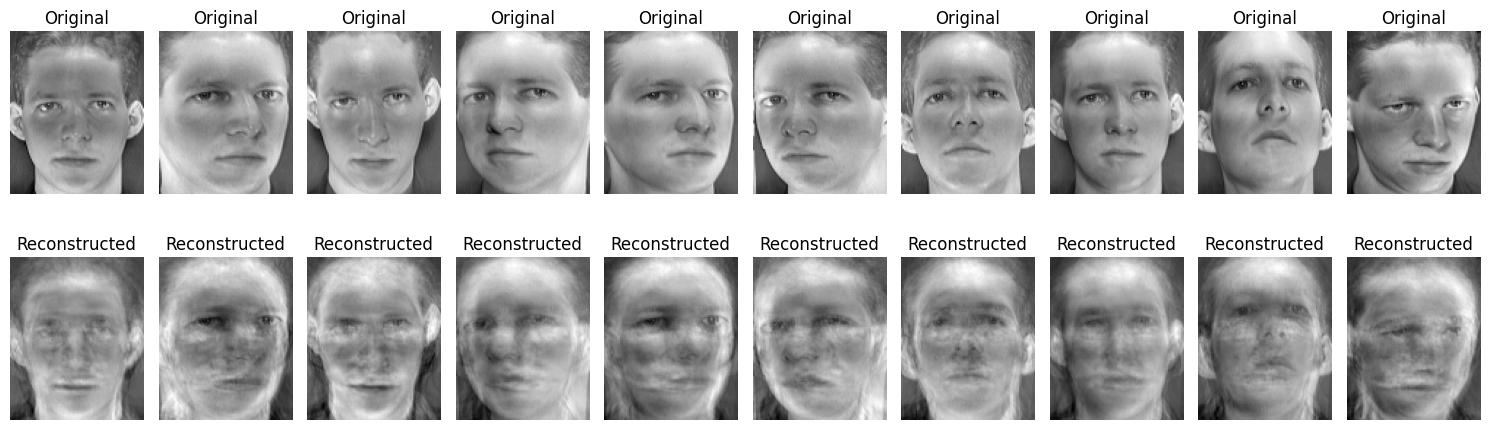

In [30]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


mean_face = np.mean(ds, axis=1, keepdims=True)
Z = ds - mean_face

pca = PCA(n_components=50)  
principal_components = pca.fit_transform(Z.T)
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

reconstructed_ds = pca.inverse_transform(principal_components)

def visualize_faces(original, reconstructed, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[:, i].reshape(112, 92), cmap='gray')
        plt.axis('off')
        plt.title('Original')

        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].reshape(112, 92), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(mean_face.reshape(112, 92), cmap='gray')
plt.title('Mean Face')
plt.axis('off')
plt.show()

visualize_faces(Z, reconstructed_ds, n=10)

#print("Principal Components Shape:", principal_components.shape)
#print("Explained Variance Ratio:", explained_variance_ratio)
#print("Cumulative Explained Variance:", cumulative_variance)




### We used 50 principal components here.

# 20 Principal Components

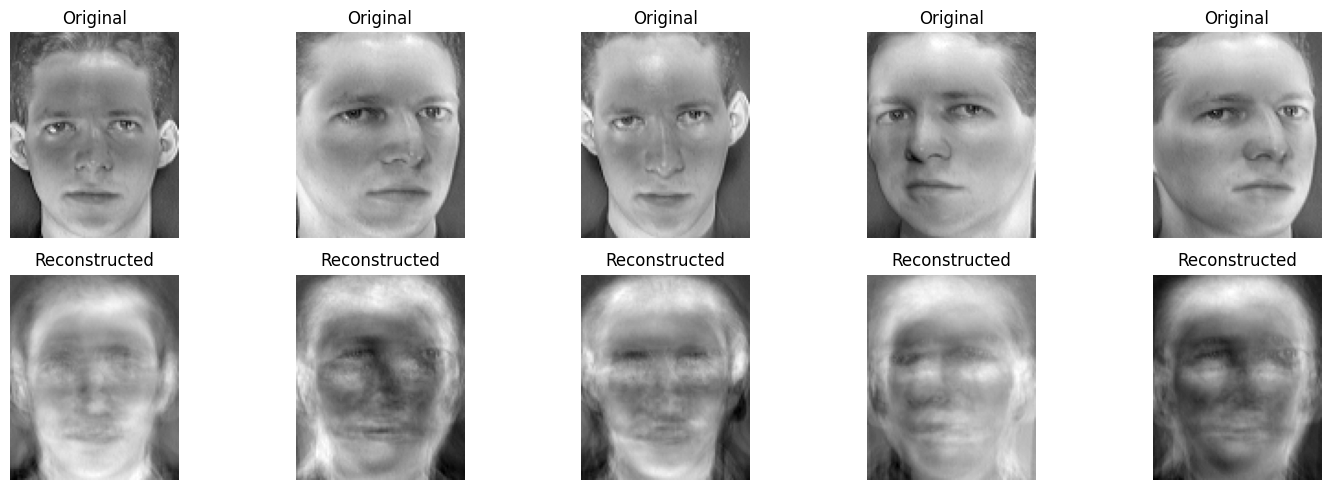

In [21]:
pca = PCA(n_components=20)  
principal_components = pca.fit_transform(Z.T)

reconstructed_ds = pca.inverse_transform(principal_components)

def visualize_faces(original, reconstructed, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[:, i].reshape(112, 92), cmap='gray')
        plt.axis('off')
        plt.title('Original')

        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].reshape(112, 92), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.tight_layout()
    plt.show()


visualize_faces(Z, reconstructed_ds, n=5)




# 100 Principal Components

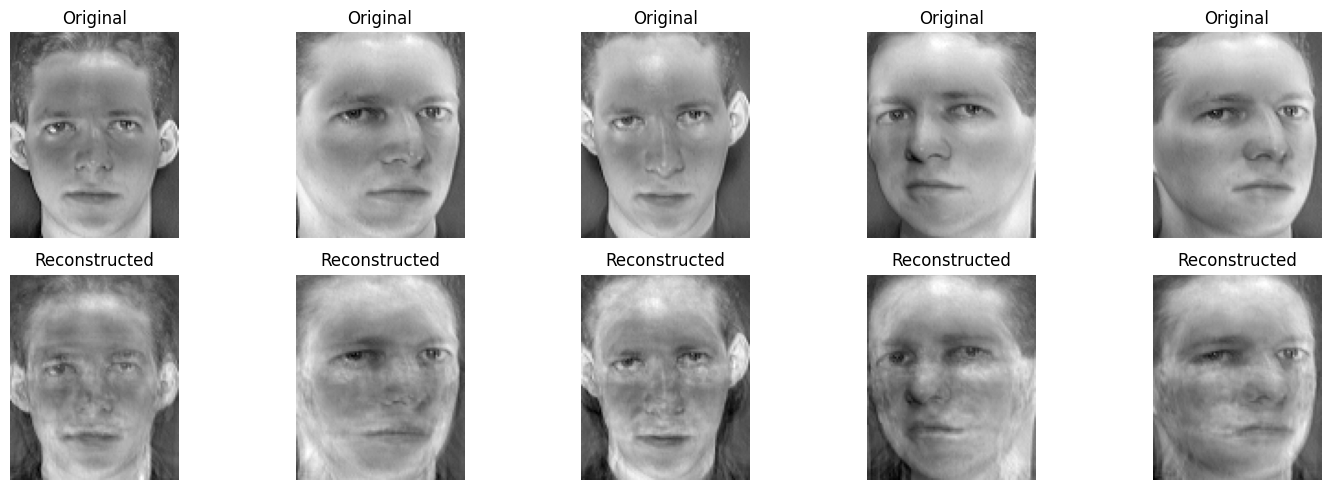

In [23]:
pca = PCA(n_components=100)  
principal_components = pca.fit_transform(Z.T)

reconstructed_ds = pca.inverse_transform(principal_components)

def visualize_faces(original, reconstructed, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[:, i].reshape(112, 92), cmap='gray')
        plt.axis('off')
        plt.title('Original')

        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].reshape(112, 92), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.tight_layout()
    plt.show()


visualize_faces(Z, reconstructed_ds, n=5)




# 200 Principal Components

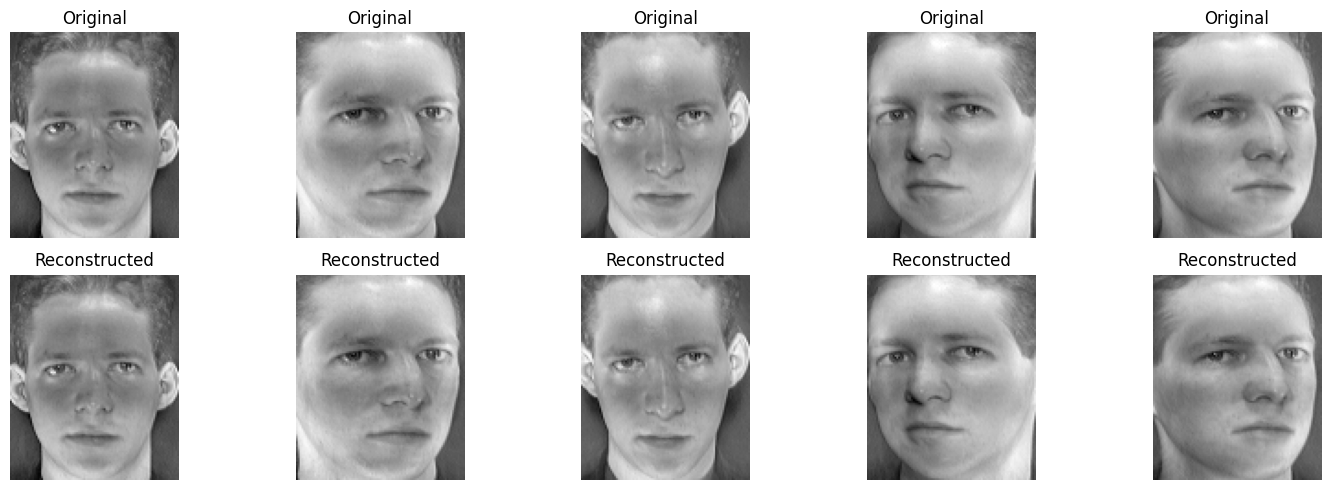

In [25]:
pca = PCA(n_components=200)  
principal_components = pca.fit_transform(Z.T)

reconstructed_ds = pca.inverse_transform(principal_components)

def visualize_faces(original, reconstructed, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[:, i].reshape(112, 92), cmap='gray')
        plt.axis('off')
        plt.title('Original')

        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].reshape(112, 92), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.tight_layout()
    plt.show()


visualize_faces(Z, reconstructed_ds, n=5)


